# [INSERT PROJECT TITLE]

[INSERT ROJECT DESCRIPTION]

## 1.0: Data ingestion

Load the MNIST handwritten digits data.

In [40]:
import keras

mnist = keras.datasets.mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()


### 1.1: Inspect the data

In [41]:
print(f"No. training data = {x_train.shape[0]}")
print(f"No. test data = {x_test.shape[0]}")
print(f"Each training/test data is an image of {x_train.shape[1]} x {x_train.shape[2]} bits.")
print(f"Y data correspond to a digit which is depicted in a corresponding 28 x 28 image. For example, for 2nd image, y = {y_train[1]}")


No. training data = 60000
No. test data = 10000
Each training/test data is an image of 28 x 28 bits.
Y data correspond to a digit which is depicted in a corresponding 28 x 28 image. For example, for 2nd image, y = 0


## 2.0: Data preparation

### 2.1: Normalise pixel values

Each pixel is [0,255]. We need to make it symmetric around 0 and make the max and min smaller so our MLP trains more effectively. 

This means we have to convert them from [0,255] to [-1.1].

In [42]:
x_train, x_test = x_train / 127.5 - 1, x_test / 127.5 - 1

### 2.2: Flatten the input data

A Multi-Layer Perceptron (MLP) does not explicitly model spatial relationships in images. Instead, it expects the input to be a one-dimensional feature vector. Therefore, each image must be flattened before being passed to the network. This means that instead of x_train.shape = (60000,28,28), it should be (60000,784)

In [43]:
import numpy as np

# Find the total number of pixels 
nb_features = np.prod(x_train.shape[1:])

# Change the shape from (n_train,28,28) to (n_train,784)
n_train = x_train.shape[0]
x_train.resize((n_train, nb_features))
print(f"After flattening, the x_train shape = {x_train.shape}")

# Change shape of test data 
n_test = x_test.shape[0]
x_test.resize((n_test, nb_features))
print(f"After flattening, the x_test shape = {x_test.shape}")

After flattening, the x_train shape = (60000, 784)
After flattening, the x_test shape = (10000, 784)


## 3.0 PCA - NOT YET IMPLEMENTED

## 4.0 Perceptrons

We will implement an iterative algorithm for training the single layer perceptron.

### 4.1 Filter data for binary classifier

As we are dealing with a binary classification problem, we will pick data points corresponding to classes 0 and 1 (handwritten digits). In  addition, we choose our binary labels to be -1 and 1, respectively. 

In [ ]:
# Create a condition mask. If the label is 1 or 0, it outputs True, otherwise False. 
cond = (y_train == 0) | (y_train == 1) 
cond_test = (y_test == 0) | (y_test == 1) 

# Extract all elements from x_train, x_test and y_train,y_test where the corresponding element from y_train / y_test satsifies the condition.
binary_x_train = x_train[cond,:]
binary_y_train = y_train[cond] # y_train is 1D
binary_x_test = x_test[cond_test,:]
binary_y_test = y_test[cond_test] # y_train is 1D


# COnvert the labels to float. By defualt its is uint8 which doesn't accept negative numbers.
binary_y_train = binary_y_train.astype(float)
binary_y_test = binary_y_test.astype(float)

# Convert all labels of 0 to -1 
binary_y_train[binary_y_train == 0] = -1
binary_y_test[binary_y_test == 0] = -1



### 4.2 Create a prediction function 

The predict function multiplies each input value by a weight and adds them together, along with a bias term. It passes the result through an activation function. The output is either -1 or 1.


In [45]:
def predict(x: np.ndarray, w: np.ndarray, b: float) -> np.ndarray:
    """
    Parameters:
        x (np.ndarray): Input matrix which is of size n x m. Where n is the number of data points and m is the feature dimensionality (i.e. 784)
        w (np.ndarray): The vector of weights of size m (i,.e. 784). This is what we need to learn. Here it is 784 elements long. 
        b (float): The bias term. 

    Returns:
        np.ndarray: A vector of size n, containing prediction values for x. These are either -1 or 1.
    """

    # Calculate the weighted sum
    weighted_sum = x @ w

    # Add the bias term
    weighted_sum_bias = weighted_sum + b

    # If the weighted sum + bias less than 0, return -1, else return 1. Ensures that labels are only -1 and 1
    prediction = np.where(weighted_sum_bias >=0, 1, -1)

    return prediction

### 4.3 Single layer perceptron 

We will use function "predict" to implement a single layer perceptron algorithm. 

In [46]:
import numpy as np

def optimize (x: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, float, float, list[float], list[int]]:
    """
    Function which based on inputs and corresponding labels, optimises the weights and the bias. 

    Parameters:
        x (np.ndarray): Input matrix which is of size n x m. Where n is the number of data points and m is the feature dimensionality (i.e. 784)
        y (np.ndarray): A vector of size n, containing prediction values for x. These are either 1 or -1
    
    Returns:
        np.ndarray: Optimised parameter vector
        float: Corresponding learned bias
        float: Classification error
        list[float]: Error list for plotting. NOTE that it skips the inifnite error for iter 0. 
        list[int]: Iteration list for plotting. NOTE that iteration 0 is not included. 
    """
    # Define local constants 
    LEARNING_RATE = 0.1 
    n, m = x.shape # Extract the number of datapoints (vectors) and their size (i.e. 784)

    # Initialise iterator and error and error list
    iter = 0
    error = np.inf # Error initially is infinity
    error_list = [] # This is a list of errors to allow plotting. 
    iter_list = [] # This is a list of each associated iteration for the errors in error list

    # Initialise weights and initial bias
    w = np.random.rand(m) # Create an array with m elements and populate it with random samples from a uniform distribution over 0,1
    b = np.random.rand() # Single random float for initial bias

    # Run the optimising loop until 1000 iteration OR error falls below 0.001
    while (iter <= 1000) & (error > 1e-3):
        
        # Reset number of wrong predictions for each iteration 
        num_wrong_predictions = 0

        # Get the prediction matrix 
        prediction = predict(x,w,b) 

        # Go over each datapoint 
        for i in range (n):

            # If the prediction is wrong, update weights, bias and error 
            if prediction[i] != y[i]:
                w = w + LEARNING_RATE * y[i] * x[i] # w = w + ηy[i]x[i]
                b = b + LEARNING_RATE * y[i] # b = b + ηy[i]
                num_wrong_predictions += 1
        
        # Calculate error for the iteration. Error = Num of Wrong Prediction / Total number of samples
        error = num_wrong_predictions / n
        
        # Add the iteration error to the list. 
        error_list.append(error)
        iter_list.append(iter)

        # Increase the iterator
        iter += 1
    
    return w, b, error, error_list, iter_list

### 4.4 Train the single layer perceptron

In [47]:
the_w, the_b, training_error, error_list, iter_list = optimize(binary_x_train, binary_y_train)

print (f"Training error (%) = {training_error * 100} %")

Training error (%) = 0.09474930911962101 %


### 4.5 Create a test fuction 

In [ ]:
def test(test_x: np.ndarray, test_y: np.ndarray, optimised_w: np.ndarray, optimised_b: float) -> float:
    """
    Function which accepts the test data (x and y) and optimised parameters and outputes the testing_error. 
    
    Parameters:
        x (np.ndarray): Input matrix of test datawhich is of size n x m. Where n is the number of data points and m is the feature dimensionality (i.e. 784)
        y (np.ndarray): A vector of size n, containing test data prediction values for x. These are either 1 or -1
        optimised_w (np.ndarray): A vector of size m, containing the optimised weights. 
        optimised_b (float): The optimised bias. 

    Returns:
        float: Testing error. 
    """
    # Extract the size and number of features of test data. 
    n,m = test_x.shape

    # Obtain test predictions. Use the optimised weights and bias
    test_predictions = predict(test_x,optimised_w,optimised_b)

    # Obtain the testing_error
    num_wrong_predictions = 0
    for i in range (n):
        
        if test_y[i] != test_predictions [i]:
            num_wrong_predictions +=1
    
    # Calculate testing error
    testing_error = num_wrong_predictions/n

    return testing_error

### 4.5 Error plots

/var/folders/dn/yfx4xw_15yg558hg5tb1flzc0000gn/T/ipykernel_61274/621626456.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0, 0.5, 'Training Error')

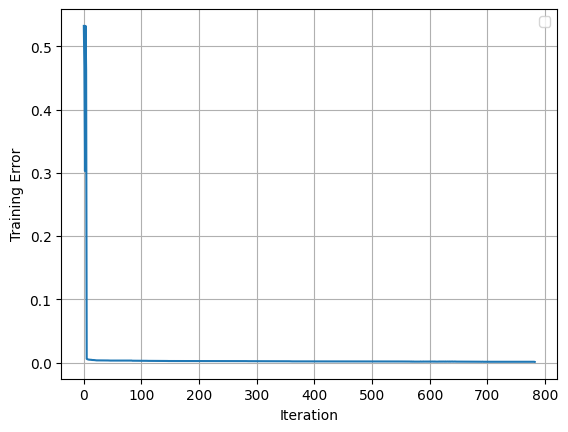

In [48]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(iter_list, error_list)
plt.legend()
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel("Training Error")